In [1]:
import importlib
import warnings
from collections import defaultdict
import altair as alt
from ipywidgets import Video
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

warnings.filterwarnings('ignore')

def get_data():
    import pandas as pd
    data = []
    mn, mx = float("+inf"), float("-inf")

    for k, arr in loss_tracker.items():
        for i, v in enumerate(arr):
            data.append(dict(model=k, metric='loss', loss=v, epoch=i))
            mn = min(v, mn)
            mx = max(v, mx)
    return pd.DataFrame(data), mn, mx

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import taranis
import torch

loss_tracker = defaultdict(list)

# Machine Learning Primer



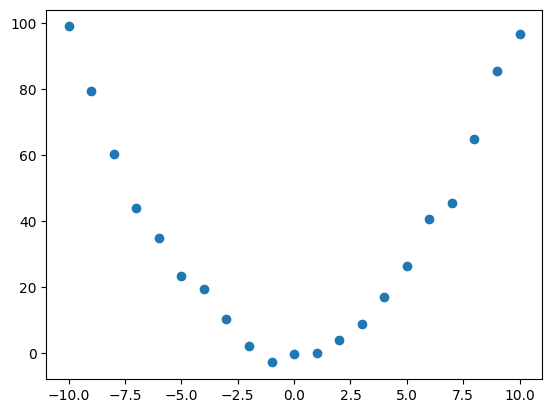

In [4]:
eps = np.random.normal(0, 3, 21)
x = np.asarray(list(range(-10, 11)))
y = x ** 2 + eps

plt.scatter(x, y)

 Linear regression does not work for non linear data

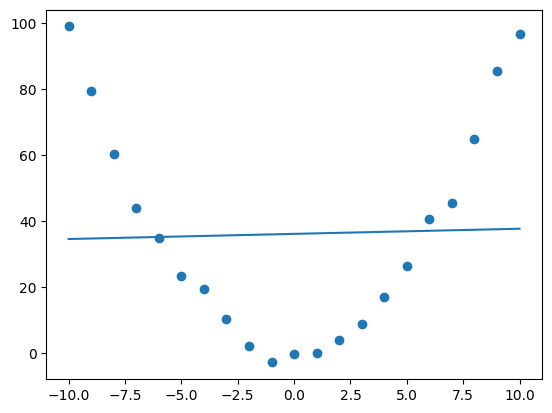

In [5]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x]
plt.scatter(x, y)
plt.plot(x, pred)

If we know the non linearity we can linearize the relationship
by applying it, the resulting problem becomes linear again

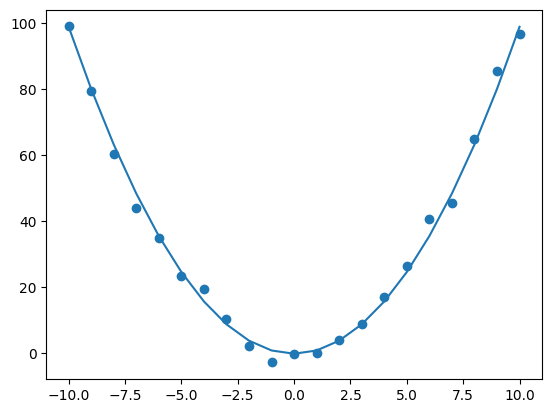

In [6]:
reg = LinearRegression().fit((x ** 2).reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x ** 2]
plt.scatter(x, y)
plt.plot(x, pred)

The problem is: there is an infinity of non linearities and the data can get pretty complex for find non linearity by ourself is not an option. Thankfully Neural Network can approximate any functions and thus learn the non linearity for us.

# Making a Linear Regression in Pytorch

In [7]:
model = nn.Sequential(
    nn.Linear(1, 1),      # 1 Input 1 output : a * x + b
)

In [8]:
def to_tensor(v):
    return torch.tensor(v, dtype=torch.float).unsqueeze(1)


def to_array(v):
    return v.detach().numpy()

##  Generate data

In [9]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2

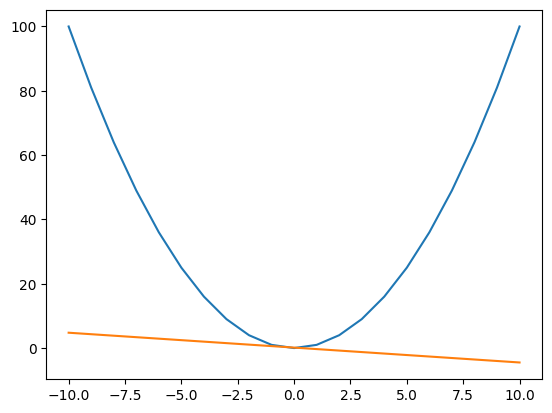

In [10]:
def show_model_estimate(model, x, y):    
    pred = to_array(model(to_tensor(x)))

    plt.plot(x, y)
    plt.plot(x, pred)
    
show_model_estimate(model, x, y)

2409.62060546875
1438.240478515625
1071.8614501953125
1068.2747802734375
1068.293212890625
1068.3115234375
1068.329833984375
1068.3480224609375
1068.366455078125
1068.385009765625


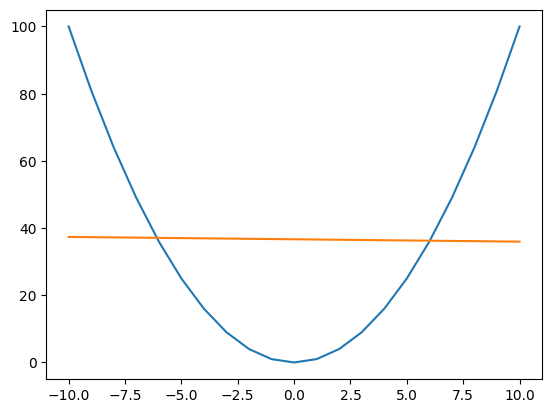

In [11]:
def train_reg(model, x, y, epoch=100, lr=1):
    optimizer = optim.Adadelta(model.parameters(), lr=1)

    for i in range(epoch):
        
        optimizer.zero_grad()                  # Clear derivative
        
        pred = model(to_tensor(x))             # Make Prediction
         
        loss = F.mse_loss(pred, to_tensor(y))  # Grade prediction
        
        loss.backward()                        # Compute derivative
        
        optimizer.step()                       # Update weights

        if i % (epoch / 10) == 0:
            print(loss.item())
            

train_reg(model, x, y, 20000)
show_model_estimate(model, x, y)

# Making Non Linear Regression

## Making the Model deeper ?

In [12]:
model = nn.Sequential(
    nn.Linear(1, 100),      #  o1  = x * w1 + b1     x: (N x 1) w1: (1 x 100)  b1: (1 x 100) o1: (N x 100)
    nn.Linear(100, 30),     #  o2 = o1 * w2 + b2                w2: (100 x 30) b2: (1 x  30) o2: (N x 30)
    nn.Linear(30, 1)        #  o3 = o2 * w3 + b3                w3: (30 x 1)   b3: (1 x 1)   
)
 
#  o3 = ((x * w1 + b1) * w2 + b2) * w3 + b3
#  o3 = (x * w1 + b1) * w2 * w3  + b2 * w3  + b3
#  o3 = x * w1* w2 * w3  + b1 * w2 * w3  + b2 * w3 + b3

# W = w1 * w2 * w3
# B = b1 * w2 * w3  + b2 * w3 + b3

# o3 = x * W + B
# STILL LINEAR

2410.27294921875
1080.425537109375
1082.2230224609375
1083.769775390625
1085.7158203125
1083.2149658203125
1078.9033203125
1076.0706787109375
1077.8626708984375
1079.921630859375


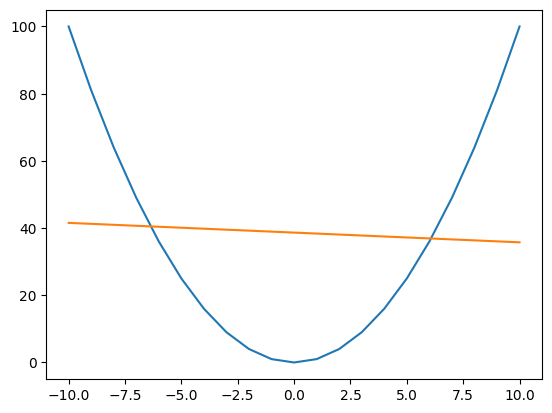

In [13]:
train_reg(model, x, y, 1000, lr=0.001)
show_model_estimate(model, x, y)

# Break linearity with a non linear activation function

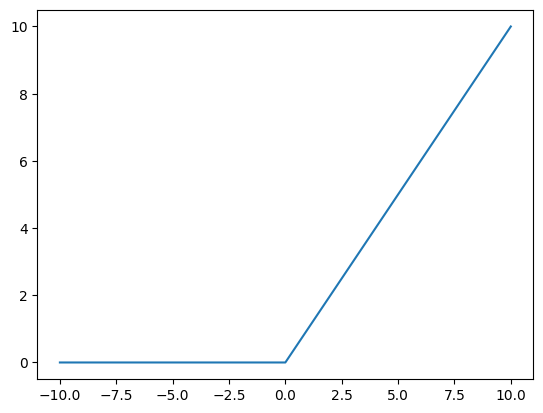

In [14]:
relu_result = to_array(nn.ReLU()(to_tensor(x)))

plt.plot(x, relu_result)

In [15]:
model = nn.Sequential(
    nn.Linear(1, 2),   # o1 = x * w1 + b1        #  o1 = [x * w11 + b11, x * w12 + b12]
    nn.ReLU(),         # o2 = max(o1, 0)         #  o2 = [max(x * w11 + b11, 0), max(x * w12 + b12, 0)]
    nn.Linear(2, 1),   # o3 = o2 * w2 + b2       #  o3 = max(x * w11 + b11, 0) * w21 + max(x * w12 + b12, 0) * w22 + b2
)

# The estimator is now non linear
# o3 = max(x * w1 + b1, 0) * w2 + b2 

# Without matrices
#
# o3 = max(x * w11 + b11, 0) * w21 + max(x * w12 + b12, 0) * w22 + b2
#     |--------------------------|  |--------------------------|
#      First Linear Approximation    Second Linear Approximation
#
#
#  We are learning a piecewise approximation of our function
#  piecewise linear is still non linear and we can get as close as we want by
#  increasing the number of neurons.
#
#  https://en.wikipedia.org/wiki/Piecewise_linear_function


2426.96826171875
2336.973876953125
1563.68603515625
1255.4010009765625
1230.222412109375
1203.4251708984375
1172.954833984375
1128.062255859375
1074.408447265625
1039.5009765625


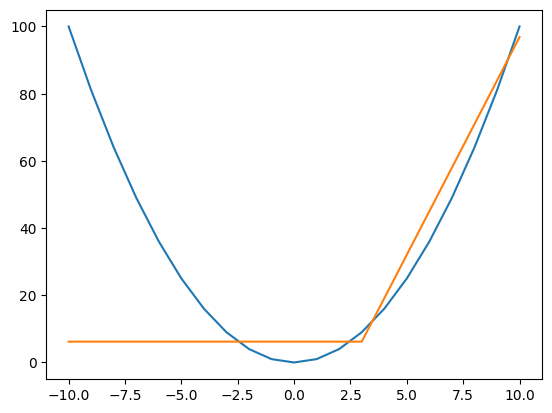

In [16]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2

train_reg(model, x, y, 1000, lr=1)
show_model_estimate(model, x, y)

2414.032470703125
2001.76318359375
1305.815185546875
1268.3109130859375
1244.1251220703125
1218.2381591796875
1190.9442138671875
1160.14404296875
1119.1380615234375
1062.0712890625


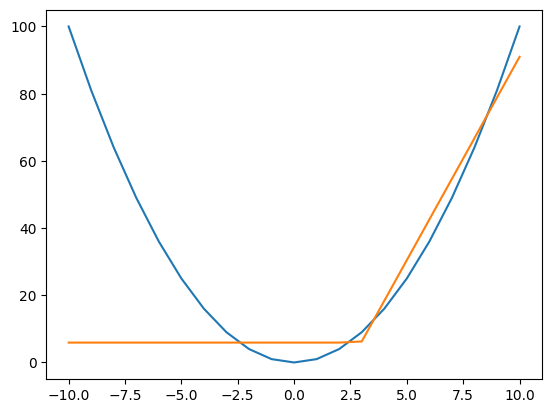

In [17]:
model = nn.Sequential(
    nn.Linear(1, 2),   # o1 = x * w1 + b1        #  o1 = [x * w11 + b11, x * w12 + b12]
    nn.ReLU(),         # o2 = max(o1, 0)         #  o2 = [max(x * w11 + b11, 0), max(x * w12 + b12, 0)]
    nn.Linear(2, 1),   # o3 = o2 * w2 + b2       #  o3 = max(x * w11 + b11, 0) * w21 + max(x * w12 + b12, 0) * w22 + b2
)

# The estimator is now non linear
# o3 = max(x * w1 + b1, 0) * w2 + b2 

train_reg(model, x, y, 1000, lr=1)
show_model_estimate(model, x, y)

2501.5927734375
2116.49462890625
1570.8572998046875
1049.6239013671875
198.28884887695312
162.3640899658203
137.38059997558594
105.74793243408203
65.42401123046875
41.9776725769043


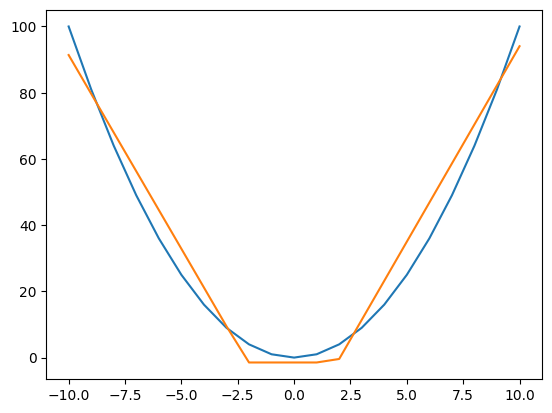

In [18]:
model = nn.Sequential(
    nn.Linear(1, 2),   # o1 = x * w1 + b1        #  o1 = [x * w11 + b11, x * w12 + b12]
    nn.ReLU(),         # o2 = max(o1, 0)         #  o2 = [max(x * w11 + b11, 0), max(x * w12 + b12, 0)]
    nn.Linear(2, 1),   # o3 = o2 * w2 + b2       #  o3 = max(x * w11 + b11, 0) * w21 + max(x * w12 + b12, 0) * w22 + b2
)

# The estimator is now non linear
# o3 = max(x * w1 + b1, 0) * w2 + b2 

train_reg(model, x, y, 1000, lr=1)
show_model_estimate(model, x, y)

# Increase number of neurons to reduce randomness

2403.158935546875
70.82972717285156
35.0295524597168
27.406238555908203
23.185237884521484
16.668447494506836
15.035250663757324
12.23182487487793
10.944645881652832
7.331655502319336


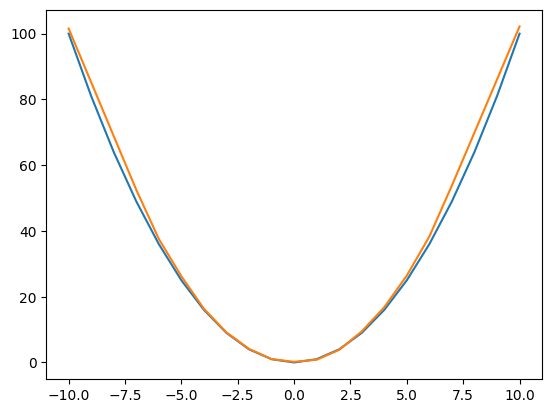

In [19]:
model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)

train_reg(model, x, y, 2000)
show_model_estimate(model, x, y)

# Non Linear correlation

Cor matrix:
 [[ 1.00000000e+00 -2.73542223e-17]
 [-2.73542223e-17  1.00000000e+00]]
--


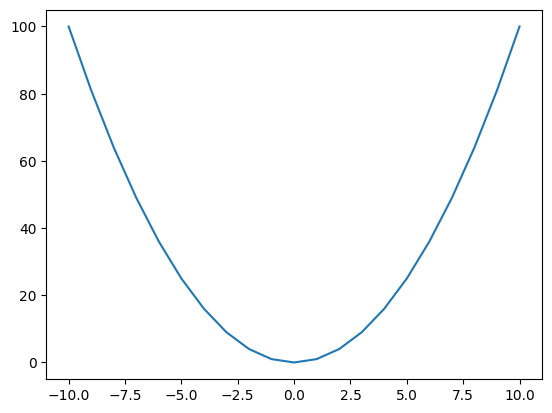

In [20]:
# Regular linear Correlation does not work well shows x, y are essentially not correlated
print('Cor matrix:\n', np.corrcoef(x, y))
print('--')
plt.plot(x, y)

[[1.         0.99923318]
 [0.99923318 1.        ]]


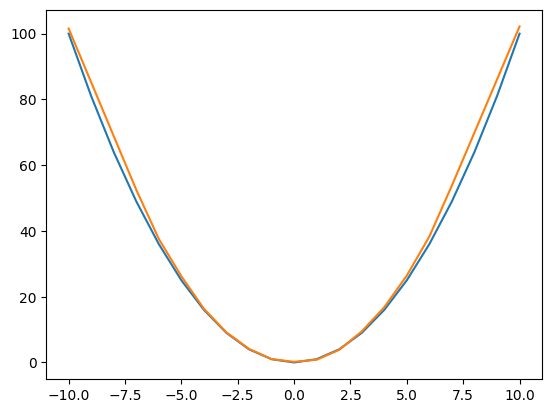

In [21]:
pred = model(to_tensor(x)).detach().squeeze().numpy()

#
# Correlation is essentially one
#
print(np.corrcoef(pred, y))

plt.plot(x, y)
plt.plot(x, pred)

# Generalization

Current models are not able to learn or infer outside of the training set
if we increase the domain of the function from $[-10, 10]$ we can see that the error will keep increasing.

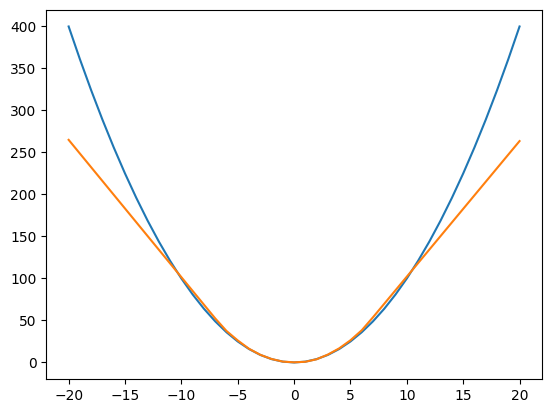

In [23]:
x = np.asarray(list(range(-20, 21)))
y = x ** 2

show_model_estimate(model, x, y)

# With sin the issue is more obvious

In [ ]:
x = np.asarray(list(range(-100, 101))) / 50
y = np.sin(x)

model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)

train_reg(model, x, y, 2000)

show_model_estimate(model, x, y)

In [ ]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

show_model_estimate(model, x, y)

In [ ]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

model = nn.Sequential(
    nn.Linear(1, 512),  
    nn.ReLU(),             
    nn.Linear(512, 1), 
)

train_reg(model, x, y, 4000)

show_model_estimate(model, x, y)

# Vision introduction

## Dataset

In [ ]:
from torchvision import datasets
from torchvision import transforms

In [ ]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True
)
print(len(dataset))

In [ ]:
image, label = dataset[0]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

In [ ]:
image, label = dataset[1]
image

In [ ]:
image, label = dataset[2]
image

Machine learning is all about creating a function `f` that will learn to approximate a function
For classification we want to approximate a function that will recognize the image it has been given in input

$ f(image) -> class\{ 0-9 \}$

## Linear Regression

## Model definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


n_class = 10


# x                 : N x 28 x 28
# x = Flatten(x)    : N x 728
# x = Linear(x)     : N x 10      = (N x 728) * (728 x 10) + 1 x 10 
# x = Softmax(x)    : N x 10      


linear = nn.Sequential(
    nn.Flatten(),                  # Flatten images from a 2D matrix to 1D => (28x28) => (784,)
    nn.LazyLinear(n_class),        # Simple (a x + b) layer that will learn `a` and `b`
    nn.Softmax(dim=1)              # Normalization so result wil be between [0, 1]
)

In [ ]:
# https://www.3blue1brown.com/lessons/neural-networks
Video.from_file("pixels-to-neurons.mp4")

## Prepare Images for the model

In [ ]:
image, label = dataset[2]
batch = transforms.ToTensor()(image) # Transform an image to a tensor/matrix

print(image)
print(batch.shape)

## Make predictions

Of course the model has not been trained yet so the result below are trash.

In [ ]:
result = linear(batch)
print('Result:  ', result.shape)

## Read Predictions

In [ ]:
print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction: `', prediction.item(), '` Truth: `', label, '`')

# Training

In [ ]:
import torch.optim as optim
import torch
import taranis.core.dataset.split as split
from taranis.core.trainer.train import mnist_dataset
from tqdm import tqdm

## Dataloading

In [ ]:
def newdataloader(batch_size=512):
    # Takes the original dataset and apply transform on the fly
    # Convert image to a tensor
    # normalize the tensor
    dataset_to_use = split.TransformedDatasetClassification(
        dataset, 
        transform=transforms.Compose([                    
            transforms.ToTensor(),                         # Transform the image to tensor
            transforms.Normalize((0.1307,), (0.3081,)),    # Normalize the image
        ])
    )

    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        dataset_to_use,
        batch_size = batch_size,
        num_workers = 1,
    )
    
    return dataloader

## Optimizer

In [ ]:
def train(name, model, epoch=2, lr=0.4):
    batch_size = 512
    dataloader = newdataloader(batch_size)
    
    model = model.cpu()

    # Gradient optimizer 
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    losses = loss_tracker[name]
    
    with tqdm(total=len(dataset) * epoch, ncols=100) as progress:

        # Repeat a few times 
        for i in range(epoch):
            total_loss = 0
            count = 0

            # Go through the dataset
            for batch, labels in dataloader:
    
                optimizer.zero_grad()                     # Clear previous derivative

                probabilities = model(batch)              # Make prediction

                loss = F.nll_loss(probabilities, labels)  # Grade the prediction 

                loss.backward()                           # Compute derivative

                optimizer.step()                          # Update parameters using derivative

                total_loss += loss.item()                 # Keep track of loss to make sure it goes down

                count += 1
                
                progress.update(batch_size)
            
            loss = total_loss / count
            losses.append(loss)
            progress.set_description(f"loss: {loss:8.4f}")
    
    return losses

# Train

In [ ]:
train('linear', linear, lr=1, epoch=2)

## Prediction

In [ ]:
image, label = dataset[2]
batch = transforms.ToTensor()(image)

image

In [ ]:
result = linear(batch)
print('Result:  ', result.shape)

print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction', prediction.item(), 'Truth:', label)
image

# Non Linearity

Model is linear only so it can only approximate linear relationships
what is we create more layers ?

In [ ]:
deepmodel_bad = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 =  
    nn.LazyLinear(64),     # r2 = (x * a1 + b1) * a2 + b2
    nn.LazyLinear(10),     # r3 = x * w + b
    nn.Softmax(dim=1)      #    w = a1 * a2* a3
                           #    b = b1 * a2* a3 + b2* a3  + b3
)

# r3 = r2 * w3 + b3
# r3 = (r1 * w2 + b2) * w3 + b3
# r3 = r1 * w2 * w3 + b2 * w3  + b3
# r3 = (batch * w1 + b1) * w2 * w3 + b2 * w3  + b3
# r3 = batch * w1 * w2 * w3 + b1 * w2 * w3 + b2 * w3  + b3
#
# r3 = batch * w + b
#  w = w1 * w2 * w3 + b1
#  b =  b1 * w2 * w3 + b2 * w3  + b3
#
#
#   MODEL is still LINEAR
#

batch = transforms.ToTensor()(image)
result = deepmodel_bad(batch)
result.shape

train('deepmodel_bad', deepmodel_bad, lr=1, epoch=2)

## Breaking Linearity

In [ ]:
#
# Adding non linear function between 
#
deepmodel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 = batch * w1 + b1
    nn.ReLU(),             # r2 = max(r1, 0)
    nn.LazyLinear(64),     # r3 = r3 * w3 + b3
    nn.ReLU(),             # r4 = max(r3, 0)
    nn.LazyLinear(10),     # r5 = r4 * w4 + b4
    nn.Softmax(dim=1)  
)

#
# Layers cannot be factorized anymore
#
batch = transforms.ToTensor()(image)
result = deepmodel(batch)

# How does training work ?
train('deepmodel', deepmodel, lr=1, epoch=2)

# Mesuring network's precision

In [ ]:
def test_model(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST('../data', train=False,  transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=4096, num_workers=1) 
    
    total = len(dataset)
    model = model.cpu()
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        
        for batch, labels in loader:
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()  
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print(f'Accuracy {correct / total * 100:.2f} {100 - correct / total * 100:.2f}')

In [ ]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

In [ ]:
train('linear',        linear       , lr=1  , epoch=5)
train('deepmodel_bad', deepmodel_bad, lr=1  , epoch=5)
train('deepmodel',     deepmodel    , lr=1  , epoch=5)

In [ ]:
def show_loss_curve():
    data, mn, mx = get_data()
    return (
        alt.Chart(data)
        .mark_line()
        .encode(
            x=alt.X('epoch'), 
            y=alt.Y("loss", scale=alt.Scale(domain=[mn, mx])), 
            color=alt.Color(
                'model', 
                legend=alt.Legend(
                orient='none',
                legendX=130, legendY=-40,
                direction='horizontal',
                titleAnchor='middle')
            )
        )
    )

show_loss_curve()

In [ ]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Linear model plateau quickly.
Deeper model can learn more but take longer to train.

# Going faster with GPU

In [ ]:
from functools import cache

@cache
def newdataloader_cuda(batch_size=512, train=True):
    dataset_to_use = mnist_dataset(train)
    dataset_to_use.tensors = list(dataset_to_use.tensors)
    for i, t in enumerate(dataset_to_use.tensors):
        dataset_to_use.tensors[i] = t.cuda()

    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        dataset_to_use,
        batch_size = batch_size,
        num_workers = 0,
    )
    
    return dataloader


def gpu_train(name, original_model, epoch=2, lr=0.4, batch_size=4096):
    dataloader = newdataloader_cuda(batch_size)        # HERE optimized loader
    device = torch.cuda.current_device()               # HERE Get GPU device
    model = original_model.to(device)                  # HERE Convert model to GPU
    
    optimizer = optim.Adadelta(model.parameters(), lr=1)
    losses = loss_tracker[name]
    
    with tqdm(total=len(dataset) * epoch, ncols=100) as progress:
        for i in range(epoch):
            partial_losses = []
            count = 0
            for batch, labels in dataloader:
                batch, labels = batch.to(device), labels.to(device) # HERE: Convert input to GPU

                optimizer.zero_grad()

                probabilities = model(batch)

                loss = F.nll_loss(probabilities, labels)

                loss.backward()

                optimizer.step()

                partial_losses.append(loss.detach())
                count += 1
                
                progress.update(batch_size)

            total_loss = (sum(partial_losses) / count).item()
            losses.append(total_loss)
            progress.set_description(f"loss: {total_loss:8.4f}")
    
    return losses
    
def gpu_test_model(model, batch_size=4096*2):
    dataloader = newdataloader_cuda(batch_size, train=False)     # HERE optimized loader
    total = len(dataloader.dataset)
    
    device = torch.cuda.current_device()  # HERE
    model = model.to(device=device)       # HERE
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total_count = 0
        
        for batch, labels in dataloader:
            batch, labels = batch.to(device), labels.to(device) # HERE
            
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item() 
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total_count += batch.shape[0]

        assert total_count == total, f"{total_count} != {total}"
        print('Accuracy', correct / total * 100, 100 - correct / total * 100)

In [ ]:
gpu_train('linear'       , linear       , lr=0.5, epoch=5)
gpu_train('deepmodel_bad', deepmodel_bad, lr=0.5, epoch=5)
gpu_train('deepmodel'    , deepmodel    , lr=0.5, epoch=5)

In [ ]:
show_loss_curve()

In [ ]:
gpu_test_model(linear       )
gpu_test_model(deepmodel_bad)
gpu_test_model(deepmodel    )

In [ ]:
def trainfast(*args, **kwargs):
    if torch.cuda.is_available():
        return gpu_train(*args, **kwargs)
    return train(*args, **kwargs)

def testfast(*args, **kwargs):
    if torch.cuda.is_available():
        return gpu_test_model(*args, **kwargs)
    return test_model(*args, **kwargs)

# Different Layers

Linear layers are quite resource intensive often we will use specialized layer for some specific data.
For example, images will often use convolution layers.

Convolution apply a filter on an image and produce another image https://fr.wikipedia.org/wiki/Noyau_(traitement_d%27image)

In [ ]:
Video.from_file("convolution.webm")

In [ ]:
image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
print(conv.weight.shape)

batch = transforms.ToTensor()(image)
print(batch.shape)
result = conv(batch)
print(result.shape)

Example of images generated from a convolution

In [ ]:
import taranis.core.visualization as viz 
transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512))

# New network with a convolution layer

From a single image it is going to learn to generate 32 new ones to better classify them

In [ ]:
from torch.nn import init
from torch import Tensor
import math

import taranis.core.nn as ext_nn
        
conv_model = nn.Sequential(
    # ext_nn.MaskLayer((28, 28)),
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(576 * 64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1),
)

batch = transforms.ToTensor()(image).unsqueeze(0)
batch = torch.concat([batch, batch])
conv_model(batch).shape

## Training

In [ ]:
trainfast('conv_model', conv_model, lr=1, epoch=2)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=0.5, epoch=5)

## Compare

In [ ]:
show_loss_curve()

In [ ]:
testfast(linear)
testfast(deepmodel_bad)
testfast(deepmodel)
testfast(conv_model)

## Inspect learned Convolution Kernels

In [ ]:
conv_model = conv_model.cpu()

for i in range(4):
    image, label = dataset[i]
    conv = list(conv_model.children())[0]

    batch = transforms.ToTensor()(image)
    result = conv(batch)
    print(result.shape)
    plt.imshow(transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512)), cmap='Greys')
    plt.show()

In [ ]:
importlib.reload(viz)
viz.show_steps(conv_model, dataset)